# Word Density Clusters

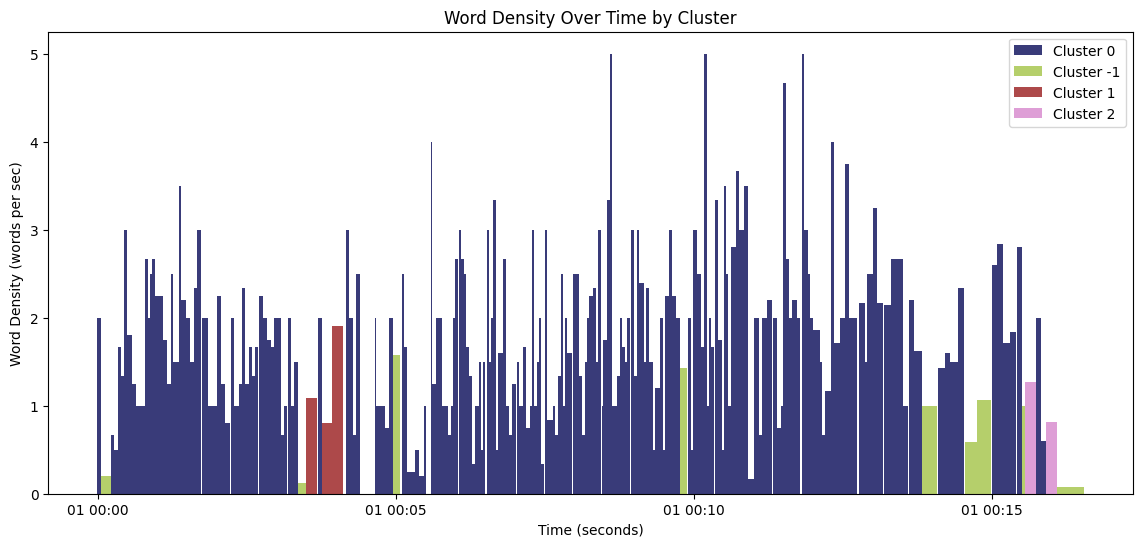

In [53]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

# Read transcript CSV
transcript_name = './transcript.csv'
transcript_df = pd.read_csv(transcript_name, quotechar='"', escapechar='\\')

# Calculate new DataFrame columns
transcript_df['word_count'] = transcript_df['text'].apply(lambda x: len(x.split()))
transcript_df['segment_length'] = transcript_df['end'] - transcript_df['start']
transcript_df['words_per_sec'] = transcript_df['word_count'] / (transcript_df['segment_length'] / 1000)

# Normalize features
features_to_normalize = ['segment_length', 'start']
transcript_df = transcript_df.join(
    transcript_df[features_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0).add_suffix('_norm')
)

# Perform clustering
clustering = DBSCAN(eps=0.05, min_samples=2).fit(transcript_df[['start_norm', 'segment_length_norm']])
transcript_df['labels'] = clustering.labels_

# Create DataFrame with one row per second
transcript_df['seconds'] = transcript_df.apply(lambda row: list(range(int(row['start']) // 1000, int(row['end']) // 1000)), axis=1)
expanded_df = transcript_df.explode('seconds')
expanded_df['seconds'] = pd.to_datetime(expanded_df['seconds'], unit='s')
expanded_df.set_index('seconds', inplace=True)

# Plotting
plt.figure(figsize=(14, 6))
unique_labels = expanded_df['labels'].unique()
colors = plt.cm.tab20b(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    subset = expanded_df[expanded_df['labels'] == label]
    plt.bar(subset.index, subset['words_per_sec'], width=pd.Timedelta(seconds=1), color=color, label=f'Cluster {label}')

plt.xlabel('Time (seconds)')
plt.ylabel('Word Density (words per sec)')
plt.title('Word Density Over Time by Cluster')
plt.legend()
plt.show()


## Saving to paragraphed transcript...

In [47]:
from datetime import timedelta

# Initialize variables
markdown_chunks = []
current_start_time = None
current_end_time = None
current_text = []

# Function to convert milliseconds to 'H:MM:SS' format
def ms_to_time(ms):
    seconds = ms // 1000
    return str(timedelta(seconds=seconds))

# Iterate through sorted DataFrame
for _, row in transcript_df.sort_values(['labels', 'start']).iterrows():
    # Extract row information
    label = row['labels']
    start_time = row['start']
    end_time = row['end']
    text = row['text']

    # Check if the current label has changed
    if label != current_label:
        if current_start_time is not None:
            markdown_chunks.append((current_start_time, current_end_time, current_text))
        current_label = label
        current_start_time = start_time
        current_text = []

    # Update variables
    current_end_time = end_time
    current_text.append(text)

# Add last chunk
if current_start_time is not None:
    markdown_chunks.append((current_start_time, current_end_time, current_text))

# Write to markdown file
with open('grouped_transcript.md', 'w') as f:
    for start_time, end_time, text_chunk in markdown_chunks:
        f.write(f"{ms_to_time(start_time)}\n")
        f.write('\n'.join(text_chunk))
        f.write(f"\n{ms_to_time(end_time)}\n\n")

# By embedding

In [55]:
import pandas as pd
import ast
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt

# Read CSV and convert embeddings to list
transcript_name = './TRANSCRIBED_DONT_DELETE/230423-Newly-Depressed/230413_2045-Madonna_Monologue.wav_embedded.csv'
transcript_df = pd.read_csv(transcript_name, quotechar='"', escapechar='\\')
transcript_df['embedding'] = transcript_df['embedding'].apply(ast.literal_eval)

# Compute word density
transcript_df["word_density"] = transcript_df["text"].apply(lambda x: len(x.split())) / (transcript_df["end"] - transcript_df["start"]) * 1000


In [66]:
# Perform hierarchical clustering based on the 'embedding' column
linked = linkage(list(transcript_df['embedding']), method='ward')
cut_off = 0.2  # Adjust as necessary
cluster_labels = fcluster(linked, cut_off, criterion='distance')

transcript_df['labels'] = cluster_labels


In [67]:
def expand_row(row):
    start, end, word_density, label = row['start'], row['end'], row['word_density'], row['labels']
    indices = range(start // 1000, end // 1000)
    return pd.DataFrame({'word_density': [word_density]*len(indices), 'labels': [label]*len(indices)}, index=indices)

# Apply the function and concatenate results
expanded_df = pd.concat([expand_row(row) for _, row in transcript_df.iterrows()])


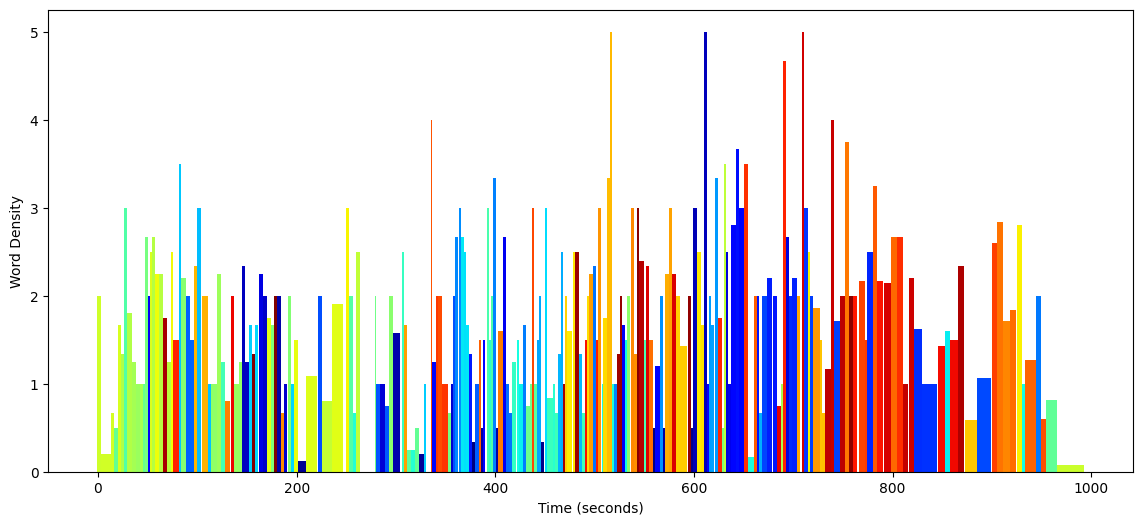

In [68]:
# Create bar chart
plt.figure(figsize=(14, 6))

unique_labels = set(expanded_df['labels'].values)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    subset = expanded_df[expanded_df['labels'] == label]
    plt.bar(subset.index, subset['word_density'], width=1, color=color)

plt.xlabel('Time (seconds)')
plt.ylabel('Word Density')
plt.show()
